In [515]:
import numpy as np
import pandas as pd
import re 
import nltk
import spacy
import string
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [516]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics


import string
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [517]:
from nltk.stem.porter import PorterStemmer

from nltk.corpus import wordnet

In [518]:
file_path = "dataset_sms_spam_bhs_indonesia_v1/dataset_sms_spam_v1.csv"

df = pd.read_csv(file_path, encoding='latin-1')

In [519]:
df.dropna(how="any", inplace=True, axis=1)
df.columns = ['text', 'label']

df.head()

,text,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


In [520]:
df.columns

Index(['text', 'label'], dtype='object')

In [521]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1143 non-null   object
 1   label   1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


In [522]:
df.describe()

,label
count,1143.000000
mean,0.711286
std,0.790001
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,2.000000


In [523]:
df.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
0       569    568  bebas nama1, terus nanti kalau ada tgl libur, ...    2
1       335    335  Jika anda bermasalah dgn CC/KT@, stres dgn bun...    1
2       239    239  [PROMO] Beli paket Flash mulai 1GB di MY TELKO...    1

In [524]:
df['label_num'] = df.label.map({0:0, 1:1, 2:2})
df.head()

,text,label,label_num
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,2


In [525]:
df['message_len'] = df.text.apply(len)
df.head()

,text,label,label_num,message_len
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,2,153
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,2,152
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,2,152
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,2,153
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,2,113


Text(0.5, 0, 'Message Length')

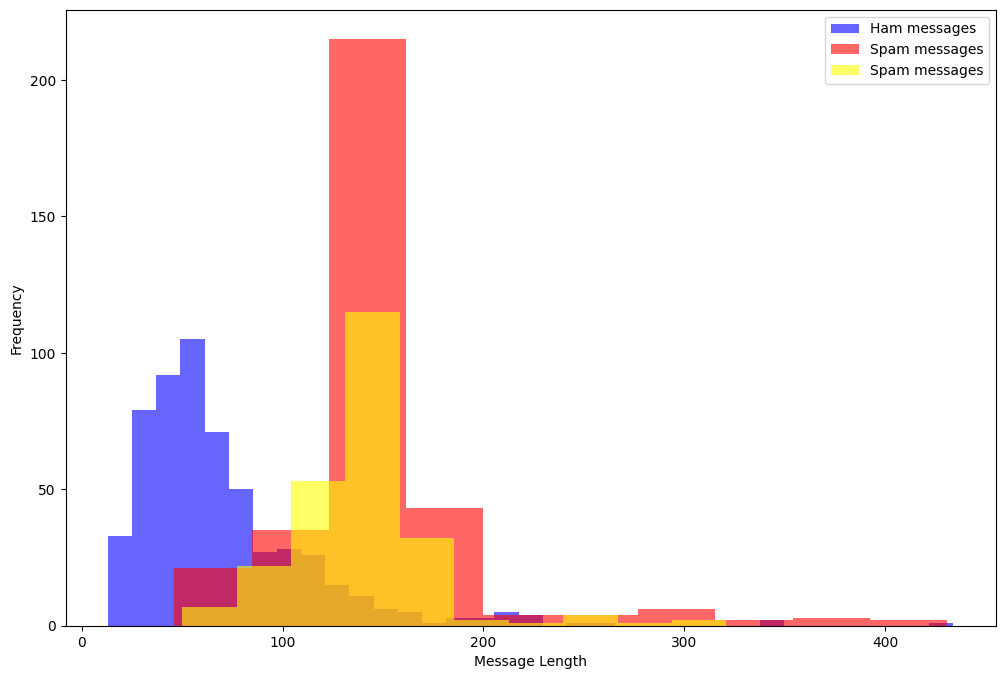

In [526]:
plt.figure(figsize=(12, 8))

df[df.label==0].message_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
df[df.label==1].message_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
df[df.label==2].message_len.plot(kind='hist', color='yellow', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

In [527]:
print(df.columns)


Index(['text', 'label', 'label_num', 'message_len'], dtype='object')


In [528]:
df[df.label==0].describe()

,label,label_num,message_len
count,569.0,569.0,569.000000
mean,0.0,0.0,70.706503
std,0.0,0.0,46.186776
min,0.0,0.0,13.000000
25%,0.0,0.0,42.000000
50%,0.0,0.0,59.000000
75%,0.0,0.0,84.000000
max,0.0,0.0,434.000000


In [529]:
df[df.label==1].describe()

,label,label_num,message_len
count,335.0,335.0,335.000000
mean,1.0,1.0,150.985075
std,0.0,0.0,49.421047
min,1.0,1.0,46.000000
25%,1.0,1.0,135.000000
50%,1.0,1.0,151.000000
75%,1.0,1.0,160.000000
max,1.0,1.0,431.000000


In [530]:
df[df.label==2].describe()

,label,label_num,message_len
count,239.0,239.0,239.000000
mean,2.0,2.0,140.702929
std,0.0,0.0,34.856483
min,2.0,2.0,50.000000
25%,2.0,2.0,123.000000
50%,2.0,2.0,142.000000
75%,2.0,2.0,156.000000
max,2.0,2.0,321.000000


In [531]:
alay_dict = pd.read_csv('new_kamusalay.csv', encoding='latin-1', header=None)

# Rename columns
alay_dict = alay_dict.rename(columns={0: 'original', 1: 'replacement'})
alay_dict.head()

,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


In [532]:
df["text_lower"] = df["text"].str.lower()
df.head()

,text,label,label_num,message_len,text_lower
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,2,153,[promo] beli paket flash mulai 1gb di my telko...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,2,152,2.5 gb/30 hari hanya rp 35 ribu spesial buat a...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,2,152,"2016-07-08 11:47:11.plg yth, sisa kuota flash ..."
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,2,153,"2016-08-07 11:29:47.plg yth, sisa kuota flash ..."
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,2,113,4.5gb/30 hari hanya rp 55 ribu spesial buat an...


In [533]:
df.drop(["text"], axis=1, inplace=True)

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text




df["text_nonalpha"] = df["text_lower"].apply(remove_nonaplhanumeric)
df.head()

,label,label_num,message_len,text_lower,text_nonalpha
0,2,2,153,[promo] beli paket flash mulai 1gb di my telko...,promo beli paket flash mulai 1gb di my telkom...
1,2,2,152,2.5 gb/30 hari hanya rp 35 ribu spesial buat a...,2 5 gb 30 hari hanya rp 35 ribu spesial buat a...
2,2,2,152,"2016-07-08 11:47:11.plg yth, sisa kuota flash ...",2016 07 08 11 47 11 plg yth sisa kuota flash a...
3,2,2,153,"2016-08-07 11:29:47.plg yth, sisa kuota flash ...",2016 08 07 11 29 47 plg yth sisa kuota flash a...
4,2,2,113,4.5gb/30 hari hanya rp 55 ribu spesial buat an...,4 5gb 30 hari hanya rp 55 ribu spesial buat an...


In [534]:
PUNCT_TO_REMOVE = string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["text_wo_punct"] = df["text_nonalpha"].apply(remove_punctuation)
df.head()
df.head()

,label,label_num,message_len,text_lower,text_nonalpha,text_wo_punct
0,2,2,153,[promo] beli paket flash mulai 1gb di my telko...,promo beli paket flash mulai 1gb di my telkom...,promo beli paket flash mulai 1gb di my telkom...
1,2,2,152,2.5 gb/30 hari hanya rp 35 ribu spesial buat a...,2 5 gb 30 hari hanya rp 35 ribu spesial buat a...,2 5 gb 30 hari hanya rp 35 ribu spesial buat a...
2,2,2,152,"2016-07-08 11:47:11.plg yth, sisa kuota flash ...",2016 07 08 11 47 11 plg yth sisa kuota flash a...,2016 07 08 11 47 11 plg yth sisa kuota flash a...
3,2,2,153,"2016-08-07 11:29:47.plg yth, sisa kuota flash ...",2016 08 07 11 29 47 plg yth sisa kuota flash a...,2016 08 07 11 29 47 plg yth sisa kuota flash a...
4,2,2,113,4.5gb/30 hari hanya rp 55 ribu spesial buat an...,4 5gb 30 hari hanya rp 55 ribu spesial buat an...,4 5gb 30 hari hanya rp 55 ribu spesial buat an...


In [535]:

slang_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))

def normalize_slang(text):
    return ' '.join([slang_dict_map[word] if word in slang_dict_map else word for word in text.split(' ')])

df["text_replacement"] = df ["text_wo_punct"].apply(normalize_slang)
df.head()

,label,label_num,message_len,text_lower,text_nonalpha,text_wo_punct,text_replacement
0,2,2,153,[promo] beli paket flash mulai 1gb di my telko...,promo beli paket flash mulai 1gb di my telkom...,promo beli paket flash mulai 1gb di my telkom...,promo beli paket flash mulai 1gb di my telkom...
1,2,2,152,2.5 gb/30 hari hanya rp 35 ribu spesial buat a...,2 5 gb 30 hari hanya rp 35 ribu spesial buat a...,2 5 gb 30 hari hanya rp 35 ribu spesial buat a...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...
2,2,2,152,"2016-07-08 11:47:11.plg yth, sisa kuota flash ...",2016 07 08 11 47 11 plg yth sisa kuota flash a...,2016 07 08 11 47 11 plg yth sisa kuota flash a...,2016 07 08 11 47 11 pulang yang terhormat sisa...
3,2,2,153,"2016-08-07 11:29:47.plg yth, sisa kuota flash ...",2016 08 07 11 29 47 plg yth sisa kuota flash a...,2016 08 07 11 29 47 plg yth sisa kuota flash a...,2016 08 07 11 29 47 pulang yang terhormat sisa...
4,2,2,113,4.5gb/30 hari hanya rp 55 ribu spesial buat an...,4 5gb 30 hari hanya rp 55 ribu spesial buat an...,4 5gb 30 hari hanya rp 55 ribu spesial buat an...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...


In [536]:
from nltk.corpus import stopwords
", ".join(stopwords.words('indonesian'))

'ada, adalah, adanya, adapun, agak, agaknya, agar, akan, akankah, akhir, akhiri, akhirnya, aku, akulah, amat, amatlah, anda, andalah, antar, antara, antaranya, apa, apaan, apabila, apakah, apalagi, apatah, artinya, asal, asalkan, atas, atau, ataukah, ataupun, awal, awalnya, bagai, bagaikan, bagaimana, bagaimanakah, bagaimanapun, bagi, bagian, bahkan, bahwa, bahwasanya, baik, bakal, bakalan, balik, banyak, bapak, baru, bawah, beberapa, begini, beginian, beginikah, beginilah, begitu, begitukah, begitulah, begitupun, bekerja, belakang, belakangan, belum, belumlah, benar, benarkah, benarlah, berada, berakhir, berakhirlah, berakhirnya, berapa, berapakah, berapalah, berapapun, berarti, berawal, berbagai, berdatangan, beri, berikan, berikut, berikutnya, berjumlah, berkali-kali, berkata, berkehendak, berkeinginan, berkenaan, berlainan, berlalu, berlangsung, berlebihan, bermacam, bermacam-macam, bermaksud, bermula, bersama, bersama-sama, bersiap, bersiap-siap, bertanya, bertanya-tanya, berturut

In [537]:
df.drop(["text_lower"], axis=1, inplace=True)

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["text_wo_stop"] = df["text_replacement"].apply(lambda text: remove_stopwords(text))
df.head()

,label,label_num,message_len,text_nonalpha,text_wo_punct,text_replacement,text_wo_stop
0,2,2,153,promo beli paket flash mulai 1gb di my telkom...,promo beli paket flash mulai 1gb di my telkom...,promo beli paket flash mulai 1gb di my telkom...,promo beli paket flash mulai 1gb di telkomsel ...
1,2,2,152,2 5 gb 30 hari hanya rp 35 ribu spesial buat a...,2 5 gb 30 hari hanya rp 35 ribu spesial buat a...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...
2,2,2,152,2016 07 08 11 47 11 plg yth sisa kuota flash a...,2016 07 08 11 47 11 plg yth sisa kuota flash a...,2016 07 08 11 47 11 pulang yang terhormat sisa...,2016 07 08 11 47 11 pulang yang terhormat sisa...
3,2,2,153,2016 08 07 11 29 47 plg yth sisa kuota flash a...,2016 08 07 11 29 47 plg yth sisa kuota flash a...,2016 08 07 11 29 47 pulang yang terhormat sisa...,2016 08 07 11 29 47 pulang yang terhormat sisa...
4,2,2,113,4 5gb 30 hari hanya rp 55 ribu spesial buat an...,4 5gb 30 hari hanya rp 55 ribu spesial buat an...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...


In [538]:
from collections import Counter
cnt = Counter()
for text in df["text_wo_stop"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('di', 449),
 ('anda', 330),
 ('yang', 259),
 ('ke', 231),
 ('info', 226),
 ('dari', 205),
 ('dan', 185),
 ('www', 180),
 ('com', 170),
 ('pin', 167)]

In [539]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["text_wo_stopfreq"] = df["text_wo_stop"].apply(lambda text: remove_freqwords(text))
df.head()

,label,label_num,message_len,text_nonalpha,text_wo_punct,text_replacement,text_wo_stop,text_wo_stopfreq
0,2,2,153,promo beli paket flash mulai 1gb di my telkom...,promo beli paket flash mulai 1gb di my telkom...,promo beli paket flash mulai 1gb di my telkom...,promo beli paket flash mulai 1gb di telkomsel ...,promo beli paket flash mulai 1gb telkomsel app...
1,2,2,152,2 5 gb 30 hari hanya rp 35 ribu spesial buat a...,2 5 gb 30 hari hanya rp 35 ribu spesial buat a...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...
2,2,2,152,2016 07 08 11 47 11 plg yth sisa kuota flash a...,2016 07 08 11 47 11 plg yth sisa kuota flash a...,2016 07 08 11 47 11 pulang yang terhormat sisa...,2016 07 08 11 47 11 pulang yang terhormat sisa...,2016 07 08 11 47 11 pulang terhormat sisa kuot...
3,2,2,153,2016 08 07 11 29 47 plg yth sisa kuota flash a...,2016 08 07 11 29 47 plg yth sisa kuota flash a...,2016 08 07 11 29 47 pulang yang terhormat sisa...,2016 08 07 11 29 47 pulang yang terhormat sisa...,2016 08 07 11 29 47 pulang terhormat sisa kuot...
4,2,2,113,4 5gb 30 hari hanya rp 55 ribu spesial buat an...,4 5gb 30 hari hanya rp 55 ribu spesial buat an...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...


In [540]:
df.drop(["text_wo_punct", "text_wo_stop"], axis=1, inplace=True)

n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df["text_wo_stopfreqrare"] = df["text_wo_stopfreq"].apply(lambda text: remove_rarewords(text))
df.head()

,label,label_num,message_len,text_nonalpha,text_replacement,text_wo_stopfreq,text_wo_stopfreqrare
0,2,2,153,promo beli paket flash mulai 1gb di my telkom...,promo beli paket flash mulai 1gb di my telkom...,promo beli paket flash mulai 1gb telkomsel app...,promo beli paket flash mulai 1gb telkomsel app...
1,2,2,152,2 5 gb 30 hari hanya rp 35 ribu spesial buat a...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...
2,2,2,152,2016 07 08 11 47 11 plg yth sisa kuota flash a...,2016 07 08 11 47 11 pulang yang terhormat sisa...,2016 07 08 11 47 11 pulang terhormat sisa kuot...,2016 07 08 11 47 11 pulang terhormat sisa kuot...
3,2,2,153,2016 08 07 11 29 47 plg yth sisa kuota flash a...,2016 08 07 11 29 47 pulang yang terhormat sisa...,2016 08 07 11 29 47 pulang terhormat sisa kuot...,2016 08 07 11 29 47 pulang terhormat sisa kuot...
4,2,2,113,4 5gb 30 hari hanya rp 55 ribu spesial buat an...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...


In [541]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [542]:
from concurrent.futures import ThreadPoolExecutor

# Stemming function for a single word
def stem_word(word):
    return stemmer.stem(word)

# Stemming function for a single text
def stem_words(text):
    with ThreadPoolExecutor() as executor:
        words = text.split()
        stemmed_words = list(executor.map(stem_word, words))
    return " ".join(stemmed_words)

# Apply the stemming function to the DataFrame column
df["text_stemmed"] = df["text_wo_stopfreqrare"].apply(stem_words)

# Display the DataFrame
df.head()

,label,label_num,message_len,text_nonalpha,text_replacement,text_wo_stopfreq,text_wo_stopfreqrare,text_stemmed
0,2,2,153,promo beli paket flash mulai 1gb di my telkom...,promo beli paket flash mulai 1gb di my telkom...,promo beli paket flash mulai 1gb telkomsel app...,promo beli paket flash mulai 1gb telkomsel app...,promo beli paket flash mulai 1gb telkomsel app...
1,2,2,152,2 5 gb 30 hari hanya rp 35 ribu spesial buat a...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...
2,2,2,152,2016 07 08 11 47 11 plg yth sisa kuota flash a...,2016 07 08 11 47 11 pulang yang terhormat sisa...,2016 07 08 11 47 11 pulang terhormat sisa kuot...,2016 07 08 11 47 11 pulang terhormat sisa kuot...,2016 07 08 11 47 11 pulang hormat sisa kuota f...
3,2,2,153,2016 08 07 11 29 47 plg yth sisa kuota flash a...,2016 08 07 11 29 47 pulang yang terhormat sisa...,2016 08 07 11 29 47 pulang terhormat sisa kuot...,2016 08 07 11 29 47 pulang terhormat sisa kuot...,2016 08 07 11 29 47 pulang hormat sisa kuota f...
4,2,2,113,4 5gb 30 hari hanya rp 55 ribu spesial buat an...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...


In [543]:
pip install Sastrawi

Note: you may need to restart the kernel to use updated packages.


In [544]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [545]:
def lemmatize_words(text):
    # Remove URLs using regular expression
    text_without_urls = re.sub(r'http\S+', '', text)
    
    # Tokenize and tag part-of-speech
    pos_tagged_text = nltk.pos_tag(text_without_urls.split())
    
    # Lemmatize words based on their part-of-speech tags
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

# Apply lemmatization to the "text" column and store the result in "text_lemmatized" column
df["no_url"] = df["text_wo_stopfreqrare"].apply(lambda text: lemmatize_words(text))
df.head()


,label,label_num,message_len,text_nonalpha,text_replacement,text_wo_stopfreq,text_wo_stopfreqrare,text_stemmed,no_url
0,2,2,153,promo beli paket flash mulai 1gb di my telkom...,promo beli paket flash mulai 1gb di my telkom...,promo beli paket flash mulai 1gb telkomsel app...,promo beli paket flash mulai 1gb telkomsel app...,promo beli paket flash mulai 1gb telkomsel app...,promo beli paket flash mulai 1gb telkomsel app...
1,2,2,152,2 5 gb 30 hari hanya rp 35 ribu spesial buat a...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...
2,2,2,152,2016 07 08 11 47 11 plg yth sisa kuota flash a...,2016 07 08 11 47 11 pulang yang terhormat sisa...,2016 07 08 11 47 11 pulang terhormat sisa kuot...,2016 07 08 11 47 11 pulang terhormat sisa kuot...,2016 07 08 11 47 11 pulang hormat sisa kuota f...,2016 07 08 11 47 11 pulang terhormat sisa kuot...
3,2,2,153,2016 08 07 11 29 47 plg yth sisa kuota flash a...,2016 08 07 11 29 47 pulang yang terhormat sisa...,2016 08 07 11 29 47 pulang terhormat sisa kuot...,2016 08 07 11 29 47 pulang terhormat sisa kuot...,2016 08 07 11 29 47 pulang hormat sisa kuota f...,2016 08 07 11 29 47 pulang terhormat sisa kuot...
4,2,2,113,4 5gb 30 hari hanya rp 55 ribu spesial buat an...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...


In [546]:
df.head()

,label,label_num,message_len,text_nonalpha,text_replacement,text_wo_stopfreq,text_wo_stopfreqrare,text_stemmed,no_url
0,2,2,153,promo beli paket flash mulai 1gb di my telkom...,promo beli paket flash mulai 1gb di my telkom...,promo beli paket flash mulai 1gb telkomsel app...,promo beli paket flash mulai 1gb telkomsel app...,promo beli paket flash mulai 1gb telkomsel app...,promo beli paket flash mulai 1gb telkomsel app...
1,2,2,152,2 5 gb 30 hari hanya rp 35 ribu spesial buat a...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...
2,2,2,152,2016 07 08 11 47 11 plg yth sisa kuota flash a...,2016 07 08 11 47 11 pulang yang terhormat sisa...,2016 07 08 11 47 11 pulang terhormat sisa kuot...,2016 07 08 11 47 11 pulang terhormat sisa kuot...,2016 07 08 11 47 11 pulang hormat sisa kuota f...,2016 07 08 11 47 11 pulang terhormat sisa kuot...
3,2,2,153,2016 08 07 11 29 47 plg yth sisa kuota flash a...,2016 08 07 11 29 47 pulang yang terhormat sisa...,2016 08 07 11 29 47 pulang terhormat sisa kuot...,2016 08 07 11 29 47 pulang terhormat sisa kuot...,2016 08 07 11 29 47 pulang hormat sisa kuota f...,2016 08 07 11 29 47 pulang terhormat sisa kuot...
4,2,2,113,4 5gb 30 hari hanya rp 55 ribu spesial buat an...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...


In [547]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   label                 1143 non-null   int64 
 1   label_num             1143 non-null   int64 
 2   message_len           1143 non-null   int64 
 3   text_nonalpha         1143 non-null   object
 4   text_replacement      1143 non-null   object
 5   text_wo_stopfreq      1143 non-null   object
 6   text_wo_stopfreqrare  1143 non-null   object
 7   text_stemmed          1143 non-null   object
 8   no_url                1143 non-null   object
dtypes: int64(3), object(6)
memory usage: 80.5+ KB


In [548]:
df[df.label==1].describe()

,label,label_num,message_len
count,335.0,335.0,335.000000
mean,1.0,1.0,150.985075
std,0.0,0.0,49.421047
min,1.0,1.0,46.000000
25%,1.0,1.0,135.000000
50%,1.0,1.0,151.000000
75%,1.0,1.0,160.000000
max,1.0,1.0,431.000000


In [549]:
df_sub = df[["label","no_url"]]
df_sub.head()


,label,no_url
0,2,promo beli paket flash mulai 1gb telkomsel app...
1,2,2 5 gb 30 hari hanya rupiah 35 ribu spesial bu...
2,2,2016 07 08 11 47 11 pulang terhormat sisa kuot...
3,2,2016 08 07 11 29 47 pulang terhormat sisa kuot...
4,2,4 5gb 30 hari hanya rupiah 55 ribu spesial bua...


In [550]:
df_sub.to_csv('df_preprocess_real.csv', index=False)
